In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

import pdb
from tqdm import tqdm

from torchsummary import summary

from bayesnn.models.bbb_het_reg import BBBHetRegModel

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
def true_f(x):
    #return np.sin(12.0 * x) + 0.66 * np.cos(25.0 * x) + 3.0
    return np.sin(x)


def get_data(train_size=100, test_size=100):
    n = train_size + test_size

    np.random.seed(42)

    #X = np.linspace(-2.0, 2.0, num=n)
    X = np.random.uniform(-1.0, 1.0, n)
    Y = true_f(X) + np.random.normal(0, 0.1, n)

    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

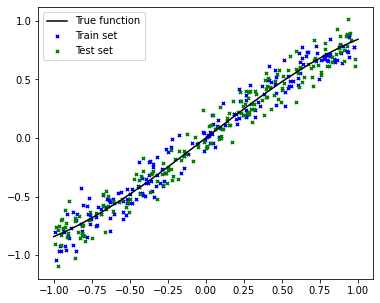

In [4]:
true_x = np.linspace(-1.0, 1.0, 1000)
true_y = true_f(true_x)

X_train, y_train, X_test, y_test = get_data(200, 200)

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_train, y_train, s=10, marker='x', color='blue', label='Train set')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.legend()

plt.show()

In [15]:
n_hidden = 10

model_reg = BBBHetRegModel(hidden_size=n_hidden).to(device)

params_reg = list(model_reg.parameters())
optimizer_reg = torch.optim.Adam(params_reg)

X_train_tensor = torch.from_numpy(X_train.reshape((-1, 1))).float().to(device)
y_train_tensor = torch.from_numpy(y_train.reshape((-1, 1))).float().to(device)

X_test_tensor = torch.from_numpy(X_test.reshape((-1, 1))).float().to(device)
y_test_tensor = torch.from_numpy(y_test.reshape((-1, 1))).float().to(device)

loss_fn = nn.MSELoss()

In [16]:
num_epoches = 2000
num_samples = 1

for ep in tqdm(range(num_epoches)):
    for x_train, y_train_labels in [(X_train_tensor, y_train_tensor)]:

        log_likelihood_total = 0
        kl_total = 0
        for i in range(num_samples):
            out_mu, out_sigma, out_kl = model_reg(x_train)
            #kl_total += out_kl
            kl_total = out_kl

            log_likelihood = torch.distributions.Normal(loc=out_mu, scale=out_sigma).log_prob(y_train_labels).sum()
            log_likelihood_total += log_likelihood

        #elbo = (log_likelihood_total - kl_total) / (num_samples * x_train.shape[0])
        elbo = log_likelihood_total / num_samples - kl_total
        (-elbo).backward()

        optimizer_reg.step()
        optimizer_reg.zero_grad()

    if (ep + 1) % 50 == 0:
        print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')

        with torch.no_grad():
            means, _, _ = model_reg(X_test_tensor)
            y_pred = means
            mse = loss_fn(y_pred, y_test_tensor).to(torch.float32).cpu().mean().numpy()

        print(f"Mean squared error at epoch number {ep} is {mse}")

  2%|▏         | 49/2000 [00:01<01:07, 28.75it/s]C:\Users\Alex\anaconda3\envs\bayesnn\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 2000/2000 [01:08<00:00, 29.23it/s]


ELBO value is -14989331.0 on epoch number 49
Mean squared error at epoch number 49 is 49.07603454589844
ELBO value is -2025477.5 on epoch number 99
Mean squared error at epoch number 99 is 35.31112289428711
ELBO value is -286709.90625 on epoch number 149
Mean squared error at epoch number 149 is 18.86294937133789
ELBO value is -189557.765625 on epoch number 199
Mean squared error at epoch number 199 is 25.31062126159668
ELBO value is -3038312.25 on epoch number 249
Mean squared error at epoch number 249 is 20.515972137451172
ELBO value is -491270.59375 on epoch number 299
Mean squared error at epoch number 299 is 27.589990615844727
ELBO value is -2712651.5 on epoch number 349
Mean squared error at epoch number 349 is 17.050277709960938
ELBO value is -157915.53125 on epoch number 399
Mean squared error at epoch number 399 is 12.686863899230957
ELBO value is -476862.96875 on epoch number 449
Mean squared error at epoch number 449 is 15.711390495300293
ELBO value is -128089.5859375 on epo

In [17]:
n_samples = 50

samples_m = np.zeros((n_samples, X_test_tensor.shape[0]))
samples_s = np.zeros_like(samples_m)
for i in range(n_samples):
    mus, sigmas, _ = model_reg(X_test_tensor, sample=False)
    np_m = mus.cpu().data.numpy()
    np_s = sigmas.cpu().data.numpy()
    samples_m[i, :] = np_m
    samples_s[i, :] = np_s

y_pred = samples_m.mean(axis=0)
#y_err = np.array(samples_m).std(axis=0)
y_err = 2 * samples_s.mean(axis=0)

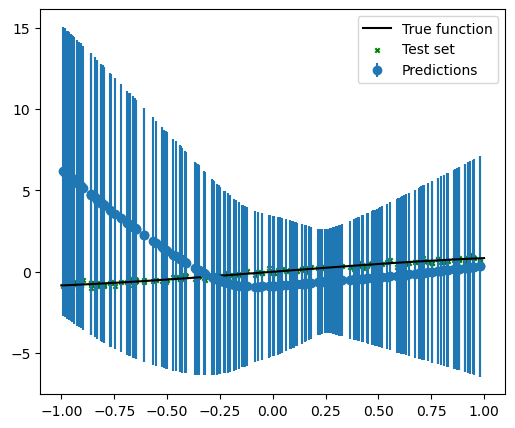

In [18]:
plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.errorbar(X_test, y_pred, yerr=y_err, fmt='o', label='Predictions')

plt.legend()

plt.show()

In [9]:
w1 = model_reg.layer1.W_mu.cpu().data.numpy()
w2 = model_reg.layer2.W_mu.cpu().data.numpy()
w3 = model_reg.layer3.W_mu.cpu().data.numpy()

b1 = model_reg.layer1.bias_mu.cpu().data.numpy()

In [10]:
model_simple =  nn.Sequential(
          nn.Linear(1, 10),
          nn.ReLU(),
          nn.Linear(10, 10),
          nn.ReLU(),
          nn.Linear(10, 1)
        ).to(device)

optimizer_simple = torch.optim.Adam(model_simple.parameters())

In [11]:
for ep in tqdm(range(num_epoches)):
    for x_train, y_train_labels in [(X_train_tensor, y_train_tensor)]:
        optimizer_simple.zero_grad()

        loss = loss_fn(model_simple(x_train), y_train_labels)

        loss.backward()

        optimizer_simple.step()

        if (ep + 1) % 50 == 0:
            #print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')

            with torch.no_grad():
                y_pred = model_simple(X_test_tensor)
                mse = loss_fn(y_pred, y_test_tensor).to(torch.float32).cpu().mean().numpy()

            print(f"Mean squared error at epoch number {ep} is {mse}")

100%|██████████| 2000/2000 [00:11<00:00, 169.80it/s]


Mean squared error at epoch number 49 is 0.17425605654716492
Mean squared error at epoch number 99 is 0.0680358037352562
Mean squared error at epoch number 149 is 0.015480930916965008
Mean squared error at epoch number 199 is 0.012282428331673145
Mean squared error at epoch number 249 is 0.011380353011190891
Mean squared error at epoch number 299 is 0.011113913729786873
Mean squared error at epoch number 349 is 0.010936303064227104
Mean squared error at epoch number 399 is 0.010854088701307774
Mean squared error at epoch number 449 is 0.01083857286721468
Mean squared error at epoch number 499 is 0.010850148275494576
Mean squared error at epoch number 549 is 0.010865408927202225
Mean squared error at epoch number 599 is 0.010905067436397076
Mean squared error at epoch number 649 is 0.01094428263604641
Mean squared error at epoch number 699 is 0.010949907824397087
Mean squared error at epoch number 749 is 0.010953232645988464
Mean squared error at epoch number 799 is 0.010967213660478592

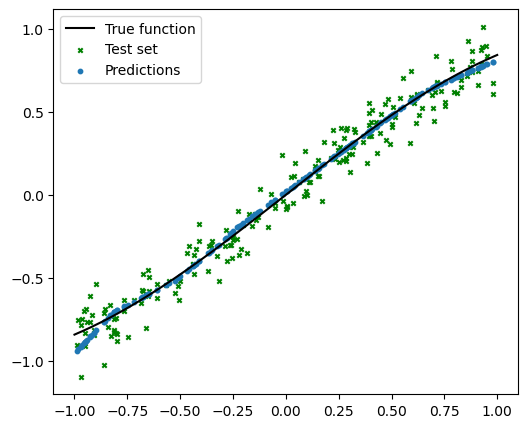

In [12]:
y_pred = model_simple(X_test_tensor).cpu().data.numpy()

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.scatter(X_test, y_pred, s=10, marker='o', label='Predictions')

plt.legend()

plt.show()